# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.NaN);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "Description"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.9/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


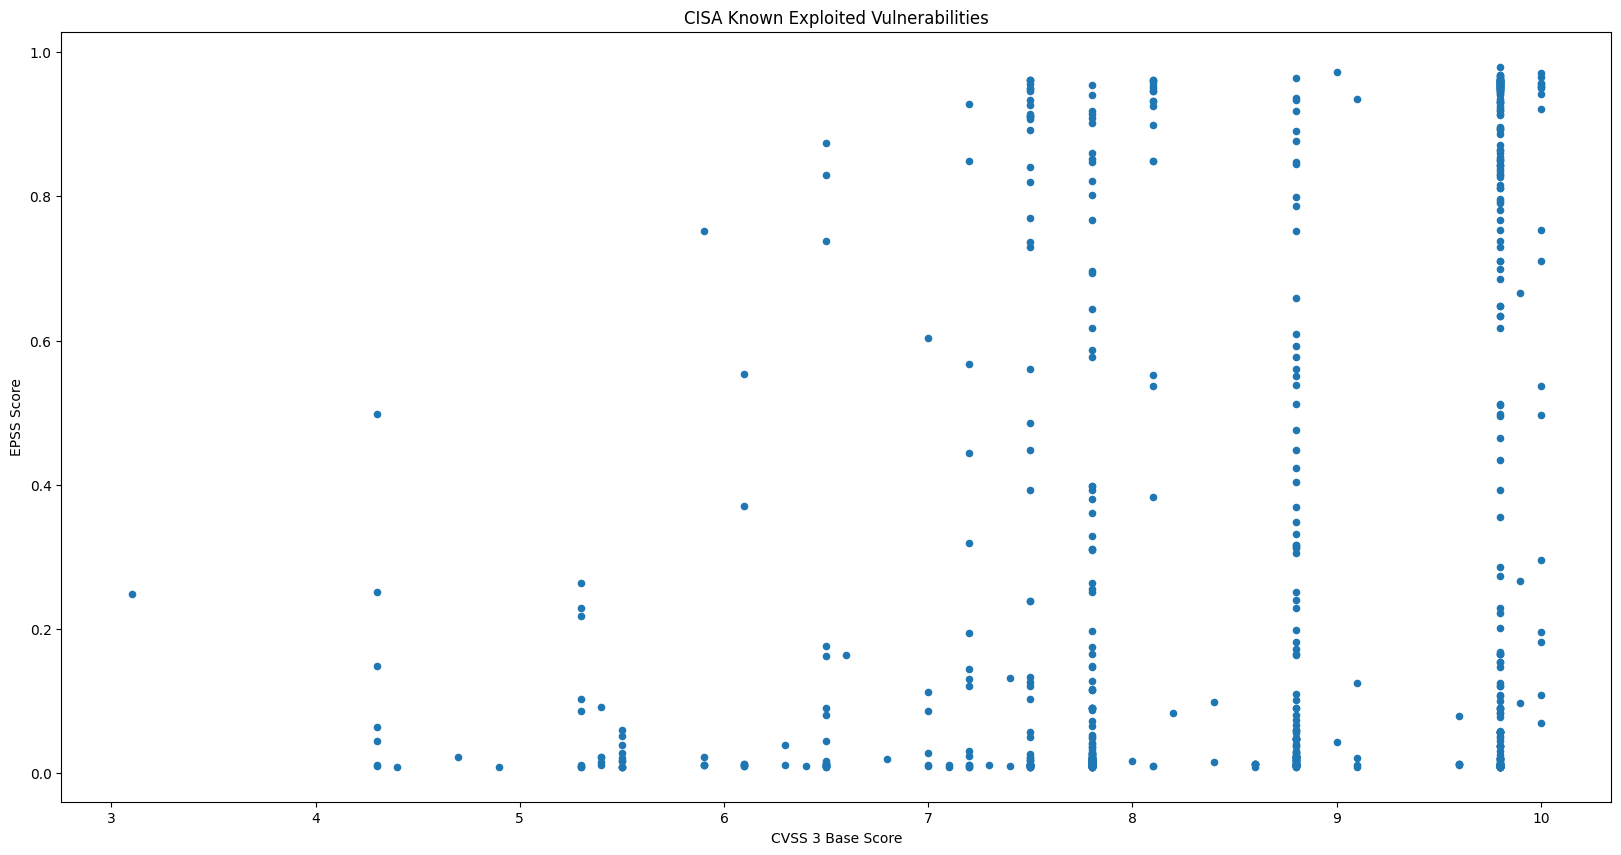

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CVS

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

/opt/hostedtoolcache/Python/3.10.9/x64/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


,CVE,CVSS3,EPSS,Description
0,CVE-2021-27104,9.8,0.01440,Accellion FTA 9_12_370 and earlier is affected...
1,CVE-2021-27102,7.8,0.01005,Accellion FTA 9_12_411 and earlier is affected...
2,CVE-2021-27101,9.8,0.00885,Accellion FTA 9_12_370 and earlier is affected...
3,CVE-2021-27103,9.8,0.00885,Accellion FTA 9_12_411 and earlier is affected...
4,CVE-2021-21017,8.8,0.31326,Acrobat Reader DC versions versions 2020.013.2...
5,CVE-2021-28550,8.8,0.01282,Acrobat Reader DC versions versions 2021.001.2...
6,CVE-2018-4939,9.8,0.04874,Adobe ColdFusion Update 5 and earlier versions...
7,CVE-2018-15961,9.8,0.95996,Adobe ColdFusion versions July 12 release (201...
8,CVE-2018-4878,9.8,0.75301,A use-after-free vulnerability was discovered ...
9,CVE-2020-5735,8.8,0.04891,Amcrest cameras and NVR are vulnerable to a st...
